# 001 preprocessing
データサイズの削減、データ形式の確認などを行ったうえでデータの変換。(一部EDAも実施)

In [1]:
import pandas as pd
import torch
from torch import nn
import pickle
import time
from datetime import datetime
from tqdm import tqdm
import pyarrow.parquet as pq
import numpy as np
from matplotlib import pyplot as plt

## 軽量データ作成

In [2]:
# np_list=[]

In [3]:
# for i in tqdm(range(72)):
#     subset_train = pq.read_pandas("../src/vsb-power-line-fault-detection/train.parquet", columns=[str(j) for j in range(i*121,(i+1)*121)]).to_pandas()
#     tmp = np.array(subset_train.values.T)
#     np_list.append(tmp)

In [4]:
# X = np.concatenate(np_list)

In [5]:
# X.shape

In [6]:
# np.save('../src/train_ndarray', X)

In [7]:
# #https://www.kaggle.com/sohier/reading-the-data-with-python
# subset_train = pq.read_pandas("../src/vsb-power-line-fault-detection/train.parquet", columns=[str(i) for i in range(5)]).to_pandas()
# np.array(subset_train.values.T).shape

In [8]:
# subset_train.info()

## データ読み込み

In [9]:
train_X = np.load('../src/train_ndarray.npy')

In [10]:
train_X.shape

(8712, 800000)

In [11]:
train_X[0]

array([18, 18, 17, ..., 17, 19, 17], dtype=int8)

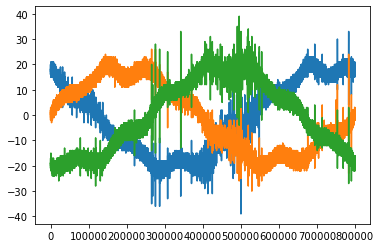

In [27]:
plt.plot(train_X[0])
plt.plot(train_X[1])
plt.plot(train_X[2])

In [14]:
train_X[0]

array([18, 18, 17, ..., 17, 19, 17], dtype=int8)

# メタデータの読み込み

In [15]:
train_meta = pd.read_csv("../src/vsb-power-line-fault-detection/metadata_train.csv")

In [18]:
train_meta.head(12)

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1
5,5,1,2,1
6,6,2,0,0
7,7,2,1,0
8,8,2,2,0
9,9,3,0,0


In [22]:
display(train_meta[train_meta["target"]==0].shape)
display(train_meta[train_meta["target"]==1].shape)

(8187, 4)

(525, 4)

異常検知の分類タスクとして考えた場合、ラベル数に偏りがあり調整が必要なことが予測されます。

同一のid_measurementに対しては、ほとんどのサンプルでは3つのphaseのtargetの数値が一致(全て0,or 全て1)していますが、一部これを満たさない信号も存在します。

In [25]:
miss = train_meta.groupby(["id_measurement"]).sum().query("target != 3 & target != 0")
print("not all postive or negative num: {}".format(miss.shape[0]))
miss

not all postive or negative num: 38


,signal_id,phase,target
id_measurement,,,
67,606,3,2
96,867,3,1
126,1137,3,1
159,1434,3,1
271,2442,3,1
301,2712,3,1
443,3990,3,1
518,4665,3,1
601,5412,3,2


ここまでの考察を踏まえると、id_measurementごとに3つのphaseが関係しあっていることが予想されます。<br>
一方で予測の仕様としては、id_measurementにつき1つ予測するよりも3つのphaseそれぞれにtargetの予測が出るのが望ましいと考えられます。<br>
これを踏まえ、最もベーシックなモデルとして、次元が<br>
[3,800000] -> [3]<br>
のように出力されるモデルを考えます。<br>
使用モデルとして、対象が時系列データであるためLSTMを検討します。MLPやLightGBMも必要に応じて比較対象として作成します。

# 参考文献
https://www.kaggle.com/go1dfish/basic-eda<br>
https://www.kaggle.com/sohier/reading-the-data-with-python<br>

## 以上